<a href="https://colab.research.google.com/github/danbutnaru-a/Proiect-IA/blob/main/p2_w2_text_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 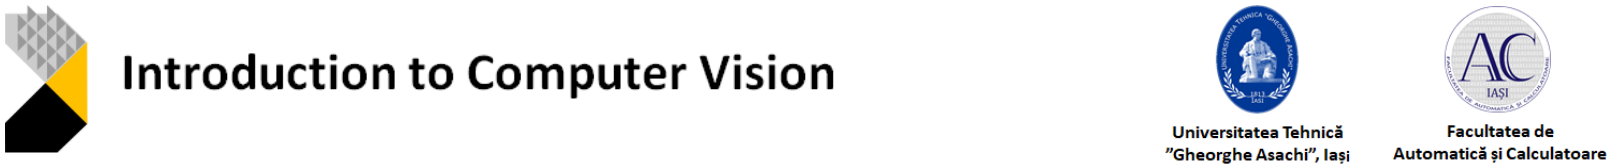

  The Intro to Computer Vision labs will be run in Google Colaboratory, a Jupyter notebook environment that runs entirely in the cloud, you don't need to download anything. To run these labs, you must have a Google account.

Step 1: click on the assignment invite link -> **Accept this assignment**. Refresh page -> individual repo for the specific assignment is created automatically

Step 2: Navigate to http://colab.research.google.com/github -> Click the **Include Private Repos** checkbox -> **select the correct repo** (SistemeDeVedereArtificiala/assignment_name-student_name) -> Click on the jupyter notebook of the current assignment

Step 3: [GitHub sign-in window] In the popup window, sign-in to your Github account and authorize Colab to read the private files.

Step 4: [in colab] **File** -> **Save a copy to GitHub**. Select the correct repository for the SPECIFIC assignment -> Click the **Include Colab Link** -> Click **OK**

Step 5: [in colab] Navigate to the **Runtime** tab --> **Change runtime type**, under **Hardware accelerator** select **GPU/TPU** (tensor processing unit) according to your needs.
  
  <font color='red'>Read the suggestions and accomplish all tasks marked with **#TODO**.

!!! At the end of each laboratory **REPEAT step 4 in order to SAVE** the answers to your private repository (individual for each assignment)</font>

# Project 2: License plate text recognition

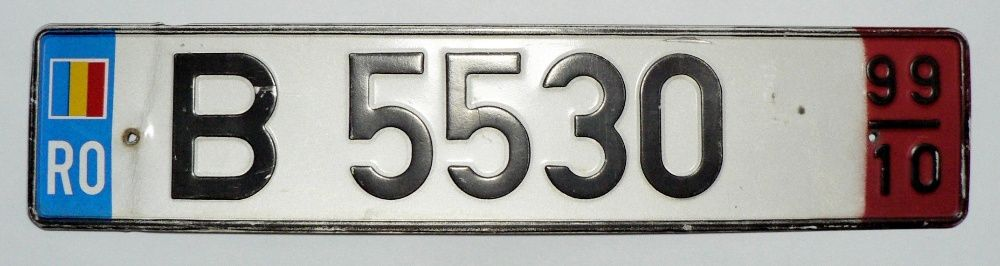

###Label:B
###Prediction output: B
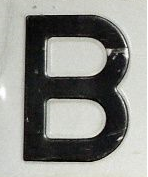

## Week 1: Character classification

In [37]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
# check for test image
!ls "/content/drive/My Drive/B (test).png"

'/content/drive/My Drive/B (test).png'


In [39]:
import cv2
import os
import numpy

def load_images_from_folder(folder):
  images = []
  labels = []
  for filename in os.listdir(folder):
    img = cv2.imread(os.path.join(folder,filename),0)
    if img is not None:
      img = cv2.bitwise_not(img);
      images.append(img)
      labels.append(ord(filename[0])-ord('a'))
  return images, labels

In [40]:
#Load images from folder
folder = '/content/drive/MyDrive/train_letters'

images, labels = load_images_from_folder(folder)

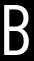

B


In [41]:
#Test if loading was successful
from google.colab.patches import cv2_imshow

cv2_imshow(images[15])
print(chr(labels[15]+65))

### Fourier Descriptors
Let $x[m]$ and $y[m]$ be the coordinates of the mth pixel on the boundary of a given 2D shape containing $N$ pixels, a complex number can be formed as $z[m]=x[m]+jy[m]$, and the Fourier Descriptor (FD) of this shape is defined as the DFT of $z[m]$:

$$Z[k] = DFT[z[m]] = \frac{1}{n}\sum_{m=0}^{N-1}z|m|e^{-j2\pi mk/N}$$

FD can be used as a representation of 2D closed shapes independent of its location, scaling, rotation and starting point. For example, we could use $M < N$ FDs corresponding to the low frequency components of the boundary to represent the 2D shape. The reconstructed shape based on these FDs approximate the shape without the details (corresponding to the high frequency components susceptible to noise). However, note that since the Fourier transform is a complex transform, the frequency spectrum has negative frequencies as well as positive frequencies, with the DC component in the middle. Therefore the inverse transform with $M< N$ components needs to contain both positive and negative terms:

$$ ẑ[m]=\sum_{k = -M/2}^{M/2} Z[k] e^{j2\pi mk/N} (m = 0, ..., N-1)$$




To compute the FD:

1. Find object contour (see cv2.findContours)
2. Create complex numbers using the (x, y) coordinates of the contour points: z = x + jy
3. Compute the Fourier transform for every complex number



In [42]:
# Function to compute the fourier descriptors
def findDescriptor(img):
    """ findDescriptor(img) finds and returns the
    Fourier-Descriptor of the image contour"""
    contour = []
    #Find object contour
    contour, hierarchy = cv2.findContours(
        img,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE,
        contour)

    #Create complex number using (x, y) coordinates of the contour points
    contour_array = contour[0][:, 0, :]
    contour_complex = numpy.empty(contour_array.shape[:-1], dtype=complex)
    contour_complex.real = contour_array[:, 0]
    contour_complex.imag = contour_array[:, 1]

    #Apply Fourier Transform (see numpy.fft)
    fourier_result = numpy.fft.fft(contour_complex)

    return fourier_result

#Function that keeps a desired number of fourier descriptors (degree)
def truncate_descriptor(descriptors, degree):
    """this function truncates an unshifted fourier descriptor array
    and returns one also unshifted"""
    descriptors = numpy.fft.fftshift(descriptors)
    center_index = len(descriptors) / 2
    descriptors = descriptors[int(center_index - (degree / 2)):int(center_index + (degree / 2))]
    descriptors = numpy.fft.ifftshift(descriptors)
    return descriptors

###Input shape and different number of Fourier Descriptors (10, 50, 300)

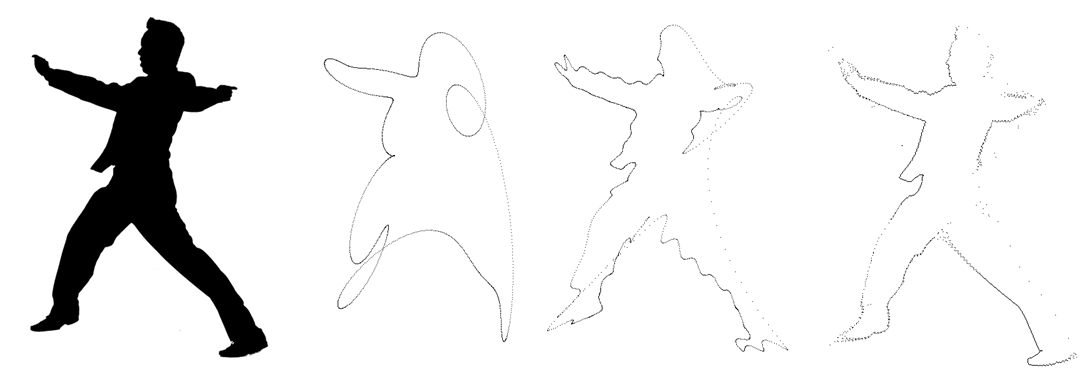

### What are Hu Moments?
**Hu Moments** ( or rather **Hu moment invariants** ) are a set of 7 numbers calculated using **central moments** that are invariant to image transformations. The first 6 moments have been proved to be invariant to **translation**, **scale**, and **rotation**, and **reflection**. While the 7th moment’s sign changes for image reflection.

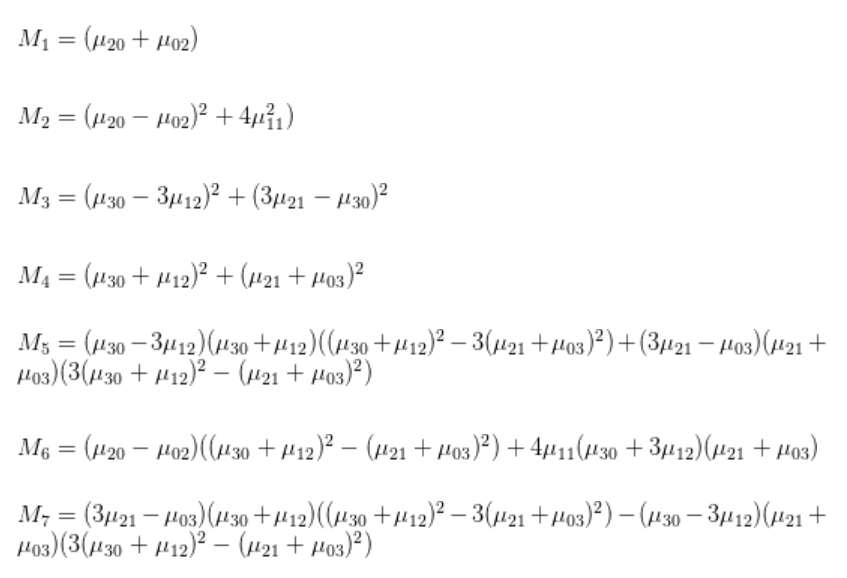

```markdown
Further reading: Analysis of Hu's moment invariants on image scaling and rotation (https://ieeexplore.ieee.org/document/5485542)
```

In [43]:
# Function that computes Hu Moments
# Steps:
# 1. threshold image (see cv2.threshold)
# 2. calculate moments (see cv2.moments)
# 3. compute Hu Moments (see cv2.HuMoments)

def fd_hu_moments(image):
  #step 1 => threshold
  _,image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)

  #step2 => moments
  moments = cv2.moments(image)

  #step 3 => Hu Moments
  huMoments = cv2.HuMoments(moments).flatten()

  return huMoments

### Test Hu Moments by performing geometric transformations

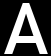

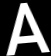

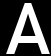

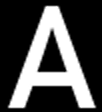

Moment 1
0.001080133042647059
0.0010826348093137257
0.001073256242647059
0.0010821384401613306
0.001080133042647059
0.001080133042647059
0.001080133042647059
Moment 2
2.079174934632768e-09
2.5374211247678936e-09
3.2334887743849103e-09
2.0856896104420534e-09
2.079174934632768e-09
2.079174934632768e-09
2.079174934632768e-09
Moment 3
1.4277900639753104e-11
1.3874047725795815e-11
1.625604434555621e-11
1.4255163236401793e-11
1.4277900639753285e-11
1.4277900639753107e-11
1.427790063975327e-11
Moment 4
3.788291218007315e-12
3.518980106329452e-12
5.774431029062539e-12
3.763319080514228e-12
3.7882912180072685e-12
3.7882912180073274e-12
3.788291218007282e-12
Moment 5
2.5045494529782897e-23
2.301498568880236e-23
-3.372233193848833e-23
2.447459375388321e-23
2.5045494529782553e-23
2.5045494529782645e-23
2.5045494529782327e-23
Moment 6
1.6126087491608105e-16
1.3460321431309177e-16
-6.673318191109832e-17
1.594712994721768e-16
1.6126087491607885e-16
1.6126087491607994e-16
1.6126087491607804e-16
Moment

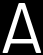

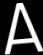

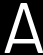

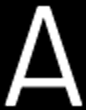

Moment 1
0.0009723132110189577
0.000980610757652826
0.0009670508464021184
0.00097978918359411
0.0009723132110189578
0.0009723132110189577
0.0009723132110189578
Moment 2
4.408177968823206e-08
4.440006966731352e-08
4.654543056968809e-08
4.35735693128267e-08
4.4081779688232107e-08
4.408177968823206e-08
4.4081779688232107e-08
Moment 3
1.4518380936484707e-11
1.4535060597879483e-11
1.5565695391634972e-11
1.5091305401723118e-11
1.4518380936484893e-11
1.4518380936484666e-11
1.4518380936484933e-11
Moment 4
1.050175909759692e-12
1.4375416145836707e-12
1.4486132465627722e-12
1.667586032838828e-12
1.0501759097596962e-12
1.0501759097596968e-12
1.0501759097596974e-12
Moment 5
3.880911799749963e-24
6.470720384112964e-24
-2.2937091425597316e-24
8.081690734072303e-24
3.880911799750036e-24
3.880911799749973e-24
3.880911799749988e-24
Moment 6
2.1489076375550254e-16
2.8743661605456914e-16
7.586519623717872e-17
3.4241493539349444e-16
2.1489076375550431e-16
2.1489076375550308e-16
2.1489076375550251e-16
Mome

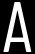

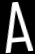

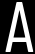

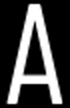

Moment 1
0.0010922210163287565
0.0010992442510397505
0.001087089239542185
0.001097957672845735
0.0010922210163287565
0.0010922210163287563
0.0010922210163287563
Moment 2
1.5380908205039976e-07
1.573717570661498e-07
1.5807710092132214e-07
1.5409274599972732e-07
1.5380908205039976e-07
1.538090820503999e-07
1.538090820503999e-07
Moment 3
1.2051080657406029e-11
1.2752857433962161e-11
1.3023573951667955e-11
1.2958356539199279e-11
1.205108065740588e-11
1.205108065740578e-11
1.2051080657406145e-11
Moment 4
2.6508794069402483e-12
3.182370919863535e-12
3.3140912652887413e-12
3.200724955420368e-12
2.6508794069403395e-12
2.6508794069402874e-12
2.650879406940299e-12
Moment 5
1.4769873606820306e-23
1.943806874994013e-23
-1.1443285416493066e-24
2.0345820079578725e-23
1.476987360682099e-23
1.4769873606820458e-23
1.4769873606820776e-23
Moment 6
1.0308411487745517e-15
1.2615000762354257e-15
6.276990048013301e-16
1.2488150407562963e-15
1.0308411487745878e-15
1.0308411487745669e-15
1.0308411487745712e-15

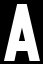

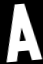

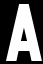

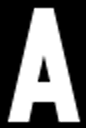

Moment 1
0.0014804681229754835
0.0014876746311019487
0.00146410010133163
0.0014810179100413219
0.0014804681229754837
0.0014804681229754837
0.001480468122975484
Moment 2
1.929393884632707e-07
2.051103870987163e-07
2.1058727881815064e-07
1.9380619943070153e-07
1.9293938846327078e-07
1.9293938846327062e-07
1.9293938846327068e-07
Moment 3
5.982908659212874e-11
6.513891425262986e-11
7.196659633937964e-11
5.992479529125932e-11
5.98290865921296e-11
5.982908659212899e-11
5.982908659212928e-11
Moment 4
5.7496342125658264e-11
5.699904624072648e-11
6.54398909145972e-11
5.7341717283193194e-11
5.749634212565819e-11
5.749634212565819e-11
5.749634212565833e-11
Moment 5
3.2492174313736957e-21
3.3556399766968186e-21
8.271848600863938e-22
3.2329445772248556e-21
3.2492174313737123e-21
3.2492174313736946e-21
3.2492174313737145e-21
Moment 6
2.4788546057199355e-14
2.4341867059502877e-14
1.6054035779347758e-14
2.4748978233061946e-14
2.4788546057199355e-14
2.4788546057199314e-14
2.478854605719936e-14
Moment 7

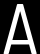

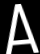

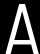

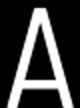

Moment 1
0.0009952594150577812
0.001001024247635241
0.0009905560922849029
0.0010009952247798102
0.0009952594150577812
0.0009952594150577812
0.0009952594150577812
Moment 2
5.516799146662412e-08
5.7928974245728646e-08
5.779537459705536e-08
5.437568076613715e-08
5.5167991466624166e-08
5.516799146662412e-08
5.5167991466624166e-08
Moment 3
8.763287439021493e-12
9.476272349301127e-12
9.923429113086198e-12
8.961305202272439e-12
8.763287439021557e-12
8.763287439021454e-12
8.763287439021598e-12
Moment 4
2.6529541313799773e-12
3.224723051045047e-12
3.0269143525739907e-12
3.3204439024342146e-12
2.652954131380042e-12
2.6529541313799834e-12
2.6529541313800347e-12
Moment 5
1.2791694412814748e-23
1.7733869516475524e-23
1.9250781724458445e-24
1.8099848408524832e-23
1.2791694412815264e-23
1.2791694412814765e-23
1.2791694412815239e-23
Moment 6
6.231210403856147e-16
7.753897604569984e-16
4.1911767726712695e-16
7.741381106664461e-16
6.231210403856304e-16
6.231210403856163e-16
6.231210403856284e-16
Moment 

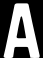

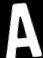

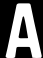

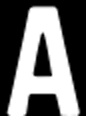

Moment 1
0.0014172132865495621
0.0014152152515529985
0.0013984703227302013
0.0014088808887154915
0.0014172132865495621
0.001417213286549562
0.001417213286549562
Moment 2
5.828397427283045e-08
7.52543712994209e-08
7.20836031991824e-08
6.068059186654494e-08
5.828397427283047e-08
5.8283974272830516e-08
5.82839742728305e-08
Moment 3
4.9282437390034026e-11
5.450301188321854e-11
7.029243706014896e-11
4.622002662453048e-11
4.928243739003343e-11
4.9282437390033845e-11
4.92824373900336e-11
Moment 4
2.1930320312463973e-11
2.1284861661250118e-11
2.948420272493072e-11
2.374955596394133e-11
2.1930320312464064e-11
2.1930320312464002e-11
2.1930320312464015e-11
Moment 5
6.838278745566195e-22
7.0350812373562835e-22
-8.374898748569401e-22
7.510901783215638e-22
6.838278745566194e-22
6.838278745566213e-22
6.838278745566203e-22
Moment 6
5.153714716310665e-15
5.359099703962917e-15
1.9426229908231545e-16
5.7177843941039325e-15
5.153714716310681e-15
5.153714716310675e-15
5.153714716310681e-15
Moment 7
2.28404

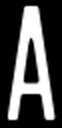

Moment 1
0.0013890000294110888
0.0013923452502265896
0.00138012348783571
0.0013894133203628278
0.0013890000294110888
0.001389000029411089
0.001389000029411089
Moment 2
6.546795252979379e-07
6.671767847734654e-07
6.691841934775605e-07
6.559151254609184e-07
6.546795252979379e-07
6.546795252979377e-07
6.546795252979377e-07
Moment 3
1.714077180949707e-11
1.7830148501095158e-11
1.8921259575004018e-11
1.7624022205522666e-11
1.7140771809497282e-11
1.7140771809497098e-11
1.7140771809497272e-11
Moment 4
3.1613146382213627e-12
3.647366191805085e-12
5.530108112244633e-12
3.5949039569567867e-12
3.1613146382213264e-12
3.1613146382213627e-12
3.1613146382213332e-12
Moment 5
2.259926712174538e-23
2.939796510037857e-23
-2.115485961105409e-23
2.8084217548365965e-23
2.259926712174513e-23
2.2599267121745364e-23
2.259926712174515e-23
Moment 6
2.5143597989637075e-15
2.947429302446891e-15
4.133923421423817e-16
2.8833559598475427e-15
2.514359798963679e-15
2.514359798963703e-15
2.5143597989636783e-15
Moment 7


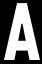

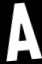

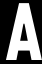

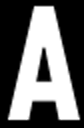

Moment 1
0.00149564432605658
0.001488398999892536
0.0014724643357187366
0.0014922541472634013
0.00149564432605658
0.00149564432605658
0.00149564432605658
Moment 2
2.4296182475213265e-07
2.5344966287522795e-07
2.6902472719973053e-07
2.443400599746305e-07
2.429618247521327e-07
2.429618247521327e-07
2.4296182475213265e-07
Moment 3
7.614878135204904e-11
8.07541181628446e-11
9.123104581125098e-11
7.431955256116948e-11
7.614878135204771e-11
7.614878135204913e-11
7.614878135204762e-11
Moment 4
4.505645784701207e-11
3.902847728079162e-11
5.640423722856102e-11
4.0312295444903876e-11
4.505645784701192e-11
4.505645784701199e-11
4.50564578470119e-11
Moment 5
2.1140349439354412e-21
1.8324838792592078e-21
-5.94299851748068e-22
1.7418722795947488e-21
2.114034943935411e-21
2.114034943935441e-21
2.114034943935412e-21
Moment 6
1.9891743164297307e-14
1.623537304151986e-14
8.849803499989368e-15
1.772742551586441e-14
1.989174316429723e-14
1.9891743164297322e-14
1.989174316429728e-14
Moment 7
1.579893779685

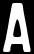

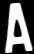

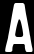

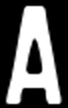

Moment 1
0.0014181730891923985
0.001426180304238146
0.0014005028591464463
0.001422099429886109
0.0014181730891923983
0.0014181730891923987
0.0014181730891923983
Moment 2
2.5296815292486695e-07
2.621521222632235e-07
2.723017766878948e-07
2.5376717661260906e-07
2.5296815292486674e-07
2.5296815292486685e-07
2.5296815292486663e-07
Moment 3
4.2721534967871087e-11
4.2665338280710904e-11
4.9306248694555295e-11
4.281284623074928e-11
4.272153496787174e-11
4.272153496787148e-11
4.272153496787129e-11
Moment 4
1.6269464217166744e-11
1.711544855484569e-11
2.3768770146580644e-11
1.7237117166218393e-11
1.6269464217166815e-11
1.626946421716668e-11
1.6269464217166893e-11
Moment 5
4.16311369886918e-22
4.616710480444466e-22
-3.3967159175430604e-22
4.607836252486669e-22
4.1631136988692356e-22
4.1631136988691717e-22
4.1631136988692516e-22
Moment 6
8.071582154905344e-15
8.692788637850435e-15
2.3208420692812993e-15
8.613068831225314e-15
8.071582154905369e-15
8.071582154905301e-15
8.07158215490542e-15
Moment 

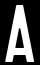

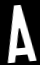

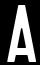

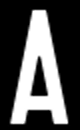

Moment 1
0.0012505393639941924
0.001255168597431693
0.001246464781410571
0.001252036718164264
0.0012505393639941924
0.0012505393639941924
0.0012505393639941926
Moment 2
2.2521559526879287e-07
2.3143005453727886e-07
2.2969656172126398e-07
2.2609682165888785e-07
2.2521559526879297e-07
2.252155952687928e-07
2.2521559526879292e-07
Moment 3
1.4773745746939183e-11
1.5342804116124993e-11
1.6211982895008655e-11
1.466852474500688e-11
1.477374574693939e-11
1.477374574693929e-11
1.4773745746939254e-11
Moment 4
2.4893054476925532e-11
2.7458968490316507e-11
2.5807659991887978e-11
2.5010253467342635e-11
2.48930544769256e-11
2.4893054476925493e-11
2.489305447692565e-11
Moment 5
4.707318482073183e-22
5.617389301072911e-22
3.674568489715388e-22
4.724732631628197e-22
4.707318482073237e-22
4.707318482073192e-22
4.70731848207323e-22
Moment 6
1.1738288238433349e-14
1.3209385332862691e-14
1.0546564592656896e-14
1.1814510504855678e-14
1.1738288238433375e-14
1.1738288238433325e-14
1.1738288238433405e-14
Momen

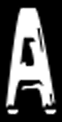

Moment 1
0.0014530203812727384
0.0014548205977066577
0.0014487397634525534
0.0014533896832579088
0.0014530203812727384
0.0014530203812727384
0.0014530203812727384
Moment 2
6.921615318460581e-07
7.100196251473187e-07
6.991152255748914e-07
6.924457266568768e-07
6.921615318460581e-07
6.921615318460581e-07
6.921615318460581e-07
Moment 3
6.482155294467072e-12
5.475208447550398e-12
1.0731261374965984e-11
6.423391494293736e-12
6.4821552944672555e-12
6.48215529446706e-12
6.4821552944672595e-12
Moment 4
7.260400083119953e-13
6.183644644803703e-13
2.8694616130499e-12
7.944121434282332e-13
7.260400083119438e-13
7.260400083120005e-13
7.26040008311944e-13
Moment 5
5.776612063284114e-25
-2.134057198669618e-25
1.3653662824170015e-23
3.7704696200097635e-25
5.776612063284951e-25
5.776612063284576e-25
5.776612063284787e-25
Moment 6
2.021843663153057e-16
2.026856398148292e-16
-1.2083920519254725e-15
2.849873706660483e-16
2.0218436631525693e-16
2.0218436631529813e-16
2.0218436631525898e-16
Moment 7
-1.465

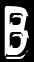

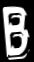

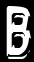

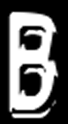

Moment 1
0.0014792909753015486
0.0014777197241141492
0.0014862925799615555
0.001479579549717768
0.0014792909753015486
0.0014792909753015488
0.0014792909753015486
Moment 2
5.521217508271106e-07
5.62966396469483e-07
5.417044301370425e-07
5.52742066524165e-07
5.521217508271103e-07
5.521217508271104e-07
5.521217508271101e-07
Moment 3
7.09119412810567e-13
3.0103298102662424e-12
3.3868861695081857e-12
7.335114828535952e-13
7.091194128105012e-13
7.091194128105504e-13
7.091194128105374e-13
Moment 4
2.555727033037978e-12
3.4625746314075766e-12
7.909327664759457e-13
2.68868401164362e-12
2.5557270330379854e-12
2.5557270330379434e-12
2.555727033037972e-12
Moment 5
-1.5610010893657366e-24
2.0104368468258626e-24
-8.188400673024353e-25
-1.862565686001427e-24
-1.5610010893656905e-24
-1.5610010893656123e-24
-1.561001089365731e-24
Moment 6
-1.5354005230559913e-15
-2.448762577356341e-15
-3.4079879511151757e-16
-1.5925029128891427e-15
-1.5354005230559536e-15
-1.5354005230559517e-15
-1.5354005230559568e-15

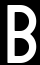

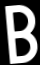

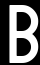

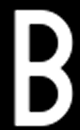

Moment 1
0.001457774990228723
0.0014183344633272592
0.001443578451627183
0.0013984777375762906
0.0014577749902287235
0.001457774990228723
0.0014577749902287232
Moment 2
3.32814785776296e-07
3.2459879863003985e-07
3.4986625285596994e-07
3.049821254380327e-07
3.3281478577629624e-07
3.328147857762961e-07
3.3281478577629635e-07
Moment 3
5.899131905329101e-12
2.415809299231899e-12
7.324153385957328e-12
5.1753846760220834e-12
5.899131905328962e-12
5.8991319053292e-12
5.89913190532937e-12
Moment 4
4.163255430541966e-12
3.5899140719758745e-12
9.708178850619539e-12
3.5965565037278055e-12
4.1632554305419126e-12
4.163255430542006e-12
4.1632554305419085e-12
Moment 5
1.449444955933049e-23
9.989093123661149e-24
1.4807627658142403e-23
1.5440744557605143e-23
1.4494449559329865e-23
1.4494449559330917e-23
1.4494449559331146e-23
Moment 6
2.1759151691575227e-15
1.1400545132719754e-15
-1.6670622109338832e-15
9.50521805885231e-16
2.175915169157502e-15
2.1759151691575334e-15
2.175915169157467e-15
Moment 7
-1

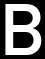

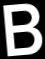

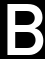

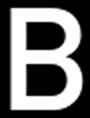

Moment 1
0.0013518828466134588
0.001348412493227564
0.0013526224847290394
0.001339874221315528
0.0013518828466134588
0.001351882846613459
0.001351882846613459
Moment 2
1.0836763868988698e-07
1.0902951358978242e-07
1.078785480286166e-07
1.0063413050593251e-07
1.0836763868988698e-07
1.0836763868988691e-07
1.0836763868988691e-07
Moment 3
2.8697036748648996e-12
3.2472752541726084e-12
3.776872197377434e-12
2.958024224441914e-12
2.8697036748649126e-12
2.869703674864764e-12
2.8697036748647417e-12
Moment 4
1.1480517617494896e-12
4.1736177764432175e-13
6.941095321701351e-13
2.888261762534429e-13
1.1480517617494814e-12
1.1480517617495583e-12
1.1480517617495359e-12
Moment 5
1.7879790100760073e-24
4.576110510954001e-25
-2.765804355702837e-25
-5.058015254154514e-26
1.7879790100760665e-24
1.787979010076137e-24
1.787979010076179e-24
Moment 6
-3.423681323325582e-16
-1.3737036770561554e-16
-1.6483956485941331e-16
-3.1727385841893154e-17
-3.4236813233256084e-16
-3.4236813233257677e-16
-3.423681323325828

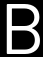

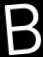

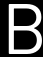

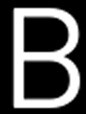

Moment 1
0.001027800820339157
0.001036997242500275
0.0010187676347948144
0.001041437579513775
0.001027800820339157
0.001027800820339157
0.001027800820339157
Moment 2
6.907354350808247e-08
7.049590974933632e-08
7.393864592708434e-08
6.872138358967806e-08
6.907354350808247e-08
6.907354350808247e-08
6.907354350808247e-08
Moment 3
7.536681483713921e-13
7.531053348960334e-13
7.980685859502455e-13
8.783939004247664e-13
7.536681483714236e-13
7.53668148371496e-13
7.536681483714712e-13
Moment 4
6.302111947508099e-14
1.3347159480163051e-14
4.755628890930613e-13
3.9555390936173896e-14
6.302111947508437e-14
6.302111947509043e-14
6.302111947508851e-14
Moment 5
-1.2601518160743204e-26
-5.482841019128444e-28
-2.57861011293157e-25
-7.372818042375263e-27
-1.2601518160743097e-26
-1.2601518160746879e-26
-1.2601518160745008e-26
Moment 6
-1.6282004378348726e-17
-2.059162309417099e-18
-1.2719299072012983e-16
-1.0346516797064594e-17
-1.6282004378349124e-17
-1.6282004378351148e-17
-1.628200437835027e-17
Momen

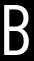

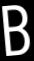

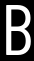

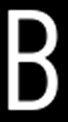

Moment 1
0.001243280206016929
0.0012580936668274089
0.0012487487396599987
0.0012532996146694829
0.001243280206016929
0.001243280206016929
0.001243280206016929
Moment 2
4.266338306355475e-07
4.414102937558457e-07
4.1948605515592674e-07
4.322397499762211e-07
4.266338306355475e-07
4.266338306355474e-07
4.266338306355474e-07
Moment 3
7.740180455159861e-14
9.95796929403955e-13
1.0241953210301427e-12
9.688740734753326e-14
7.740180455161007e-14
7.740180455158936e-14
7.740180455161059e-14
Moment 4
7.709555289195715e-13
7.184625880105946e-13
3.5974258339955667e-13
8.397196961593647e-13
7.709555289195746e-13
7.709555289195962e-13
7.709555289195921e-13
Moment 5
-1.8831115216960954e-25
-5.7098777060570015e-25
2.1795394181017372e-25
-2.390777886297766e-25
-1.8831115216962446e-25
-1.8831115216960715e-25
-1.883111521696314e-25
Moment 6
-1.5691737222625669e-16
-3.1887338306965803e-16
1.4940836177744618e-16
-1.7865186317784832e-16
-1.5691737222625533e-16
-1.5691737222626891e-16
-1.569173722262707e-16
M

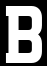

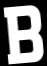

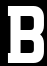

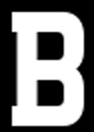

Moment 1
0.001754902843510478
0.0017125393679899956
0.0017266995798642173
0.00169855015707922
0.001754902843510478
0.001754902843510478
0.001754902843510478
Moment 2
1.9264965900052985e-07
1.9577209346337682e-07
2.1966052464643383e-07
1.773945957413822e-07
1.9264965900052964e-07
1.9264965900052985e-07
1.9264965900052966e-07
Moment 3
9.917800435904703e-12
5.146845741550382e-12
9.0767106554252e-12
1.0355440334569377e-11
9.91780043590479e-12
9.917800435904786e-12
9.917800435904663e-12
Moment 4
1.548514195246765e-11
1.201136631976389e-11
4.434893423892882e-11
1.4638584667610907e-11
1.5485141952467455e-11
1.5485141952467627e-11
1.5485141952467494e-11
Moment 5
1.6020963630744577e-22
9.170778989636113e-23
-8.831514457340482e-23
1.8016543403330995e-22
1.602096363074459e-22
1.6020963630744747e-22
1.6020963630744436e-22
Moment 6
5.24164637132821e-15
1.6149701467804349e-15
-1.0826091432006264e-14
2.843845666418299e-15
5.241646371328118e-15
5.241646371328186e-15
5.2416463713281374e-15
Moment 7
-1.

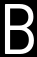

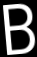

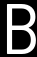

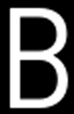

Moment 1
0.0011333090180029066
0.001150784643857543
0.0011284125812506592
0.0011465285538355737
0.0011333090180029063
0.0011333090180029066
0.0011333090180029063
Moment 2
1.9935390845750559e-07
2.0798441463999468e-07
2.0380089679023016e-07
2.0219591413496006e-07
1.993539084575054e-07
1.9935390845750564e-07
1.9935390845750545e-07
Moment 3
1.076974159864808e-12
1.096272355458511e-12
1.6112622728953347e-12
1.3481875863963082e-12
1.0769741598648913e-12
1.0769741598649877e-12
1.0769741598649307e-12
Moment 4
5.919523971800362e-16
2.3278643515968294e-14
3.3079077295451067e-13
8.744995374267088e-15
5.919523971793724e-16
5.919523971788441e-16
5.919523971793738e-16
Moment 5
1.459499875229935e-29
-3.433891606369703e-27
-2.228023255512399e-25
-9.145701857405664e-28
1.4594998752279937e-29
1.4594998752256648e-29
1.4594998752278786e-29
Moment 6
-2.5727217762551068e-19
-3.3867813945227043e-19
-1.4768042020916044e-16
2.623346894012401e-18
-2.5727217762527846e-19
-2.572721776249956e-19
-2.57272177625260

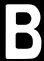

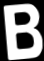

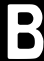

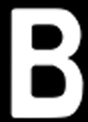

Moment 1
0.0016454781134517013
0.0016524078232370391
0.001616843729938642
0.0016423865412610343
0.0016454781134517009
0.0016454781134517013
0.0016454781134517009
Moment 2
1.51654852273603e-07
1.797529897241652e-07
1.7763738754753292e-07
1.555054968333484e-07
1.5165485227360264e-07
1.5165485227360295e-07
1.5165485227360266e-07
Moment 3
2.8370420393966207e-12
1.9489291912183622e-13
2.6832794832964183e-12
5.04609398991441e-12
2.8370420393967108e-12
2.8370420393966716e-12
2.8370420393965932e-12
Moment 4
4.115445321268729e-12
4.824962510816917e-12
1.2473025070608224e-11
4.487201544742491e-12
4.115445321268589e-12
4.115445321268739e-12
4.115445321268572e-12
Moment 5
-2.283879083875588e-24
-4.3838512518242284e-24
-6.909289830420125e-23
3.077457584075413e-24
-2.2838790838755123e-24
-2.2838790838754455e-24
-2.2838790838753562e-24
Moment 6
1.5724651921049996e-15
1.923867187592783e-15
-3.576062584304662e-15
1.7608030246948773e-15
1.5724651921049461e-15
1.5724651921050076e-15
1.5724651921049384e-1

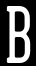

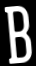

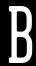

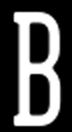

Moment 1
0.0012837506225820516
0.0012582741381612938
0.0012751618452236733
0.0012694452628929584
0.0012837506225820514
0.0012837506225820516
0.0012837506225820514
Moment 2
3.8628952448522004e-07
3.778574166192345e-07
3.9724575501722965e-07
3.746711888504597e-07
3.862895244852198e-07
3.8628952448522004e-07
3.862895244852198e-07
Moment 3
1.6005170452389167e-12
7.307381829977624e-13
1.7908832254401257e-12
1.8486020454012312e-12
1.6005170452389837e-12
1.6005170452387517e-12
1.6005170452386687e-12
Moment 4
1.2534315757587e-12
1.3763501845352276e-12
3.5755371720223953e-12
1.1754985092340716e-12
1.2534315757587356e-12
1.253431575758685e-12
1.2534315757587043e-12
Moment 5
1.6715580455409263e-24
1.3617447167622037e-24
-1.1850881150183662e-24
1.5179338261684885e-24
1.6715580455410218e-24
1.671558045540785e-24
1.6715580455407426e-24
Moment 6
5.614825203181064e-16
3.5352439575570944e-16
-1.0757511658448416e-15
1.1761980747396501e-16
5.614825203181179e-16
5.61482520318116e-16
5.614825203181382e-16


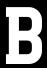

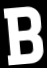

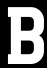

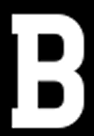

Moment 1
0.0016638254387379842
0.0016529536909835655
0.0016408018025947098
0.0016550282607501968
0.0016638254387379837
0.0016638254387379842
0.0016638254387379837
Moment 2
2.423620053514933e-07
2.508544463526855e-07
2.665535921017697e-07
2.3957850486832916e-07
2.4236200535149287e-07
2.423620053514933e-07
2.4236200535149287e-07
Moment 3
1.5034159208838563e-11
7.73533034078495e-12
2.0534621530952066e-11
1.4675755221249443e-11
1.503415920883895e-11
1.5034159208839548e-11
1.503415920883914e-11
Moment 4
1.4546492273858038e-11
1.0915258002174009e-11
3.8290093011937185e-11
1.3267496728843679e-11
1.4546492273858054e-11
1.454649227385808e-11
1.4546492273857996e-11
Moment 5
2.151181161073437e-22
9.521162784847122e-23
-1.6780911645824614e-22
1.8513125138754465e-22
2.151181161073468e-22
2.151181161073516e-22
2.1511811610734686e-22
Moment 6
4.041131192605131e-15
2.87002846859351e-15
-1.014012796269006e-14
3.577413212608861e-15
4.041131192605071e-15
4.041131192605099e-15
4.041131192605121e-15
Moment

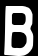

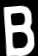

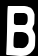

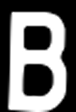

Moment 1
0.0014263092638778054
0.0014329019666224478
0.0014250686716474077
0.0014345995107891375
0.0014263092638778056
0.0014263092638778052
0.0014263092638778054
Moment 2
1.7195411127869484e-07
1.7353662560455626e-07
1.721710216601622e-07
1.741272339727787e-07
1.7195411127869492e-07
1.7195411127869495e-07
1.71954111278695e-07
Moment 3
8.668322447338784e-12
2.688624201567349e-12
2.5047803148688445e-12
8.835714035828945e-12
8.668322447338563e-12
8.668322447338952e-12
8.668322447339165e-12
Moment 4
9.088386988449986e-12
1.351765914695168e-11
1.1663986220862395e-11
8.365107051806645e-12
9.088386988449829e-12
9.088386988450007e-12
9.088386988449733e-12
Moment 5
-6.199177909400807e-23
-7.910645755914126e-23
5.85311982188622e-23
-4.787830261704089e-23
-6.199177909400708e-23
-6.199177909400853e-23
-6.199177909400582e-23
Moment 6
3.171885496393498e-15
4.924661983178849e-15
2.261957106642454e-15
3.155459677941875e-15
3.171885496393418e-15
3.1718854963935228e-15
3.171885496393433e-15
Moment 7
-5

In [44]:
#TODO for w1: Fourier & Momente pe imaginile de input rotite, oglindite, redimensionate, etc
#(see cv2.getRotationMatrix2D, cv2.warpAffine, cv2.resize)
#https://docs.opencv.org/4.1.2/da/d6e/tutorial_py_geometric_transformations.html

for img in images:
  cv2_imshow(img)
  (h, w) = img.shape[:2]
  (cX, cY) = (w // 2, h // 2)

  #Rotation
  MRotation = cv2.getRotationMatrix2D((cX, cY), 5, 1.0)
  rotated = cv2.warpAffine(img, MRotation, (w, h))
  cv2_imshow(rotated)

  #Translation: tx = translatie axa x, ty = translatie axa y
  #      1 0 tx
  #  M = 0 1 ty
  MTranslation = numpy.float32([[1,0,2],[0,1,0]])
  translated = cv2.warpAffine(img,MTranslation,(w,h))
  cv2_imshow(translated)

  #Scaling
  scaled = cv2.resize(img,None,fx=2, fy=2, interpolation = cv2.INTER_CUBIC) #fx - factor scalare pe axa x, fy = factor scalare pe axa y
  cv2_imshow(scaled)

  #Flipping
  #around x
  flipVertical = cv2.flip(img, 0)

  #around y
  flipHorizontal = cv2.flip(img, 1)

  #around xy
  flipBoth = cv2.flip(img, -1)

  hu_img = fd_hu_moments(img)
  hu_rot = fd_hu_moments(rotated)
  hu_trans= fd_hu_moments(translated)
  hu_scal = fd_hu_moments(scaled)
  hu_flipV = fd_hu_moments(flipVertical)
  hu_flipH = fd_hu_moments(flipHorizontal)
  hu_flipVH = fd_hu_moments(flipBoth)


  for i in range(0, 7):
    print("Moment "+str(i+1))
    print(hu_img[i])
    print(hu_rot[i])
    print(hu_trans[i])
    print(hu_scal[i])
    print(hu_flipV[i])
    print(hu_flipH[i])
    print(hu_flipVH[i])

## Week 2: Classifier training and testing

### What is a SVM?
A **Support Vector Machine (SVM)** is a discriminative classifier formally defined by a separating hyperplane. In other words, given **labeled training data (supervised learning)**, the algorithm outputs an optimal hyperplane which categorizes new examples.

In which sense is the hyperplane obtained optimal? Let's consider the following simple problem:

For a linearly separable set of 2D-points which belong to one of two classes, find a separating straight line.

<figure>
<center>
<img src='https://docs.opencv.org/4.1.2/separating-lines.png' />
<figcaption>In this example we deal with lines and points in the Cartesian plane instead of hyperplanes and vectors in a high dimensional space. This is a simplification of the problem.It is important to understand that this is done only because our intuition is better built from examples that are easy to imagine. However, the same concepts apply to tasks where the examples to classify lie in a space whose dimension is higher than two</figcaption></center>
</figure>

In the above picture you can see that there exists multiple lines that offer a solution to the problem. Is any of them better than the others? We can intuitively define a criterion to estimate the worth of the lines: A line is bad if it passes too close to the points because it will be noise sensitive and it will not generalize correctly. Therefore, our goal should be to find the line passing as far as possible from all points.

Then, the operation of the SVM algorithm is based on finding the hyperplane that gives the largest minimum distance to the training examples. Twice, this distance receives the important name of margin within SVM's theory. Therefore, the optimal separating hyperplane maximizes the margin of the training data.

<figure>
<center>
<img src='https://docs.opencv.org/4.1.2/optimal-hyperplane.png' />
</figure>

**How is the optimal hyperplane computed?**
Let's introduce the notation used to define formally a hyperplane:

$$f(x) = 	\beta_{0}+\beta^Tx,$$
where $\beta$ is known as the *weight vector* $\beta_{0}$ as *the bias*.

```markdown
See also: A more in depth description of this and hyperplanes you can find in the section 4.5 (Separating Hyperplanes) of the book: Elements of Statistical Learning by T. Hastie, R. Tibshirani and J. H. Friedman
```

The optimal hyperplane can be represented in an infinite number of different ways by scaling of $\beta$  and $\beta_{0}$. As a matter of convention, among all the possible representations of the hyperplane, the one chosen is:

$$|\beta_{0}+\beta^Tx| = 1,$$

where $x$ symbolizes the training examples closest to the hyperplane. In general, the training examples that are closest to the hyperplane are called support vectors. This representation is known as the canonical hyperplane.

Now, we use the result of geometry that gives the distance between a point $x$ and a hyperplane $(\beta,\beta_{0})$:


$$distance = \frac{|\beta_{0}+\beta^Tx|}{||\beta||}.$$

In particular, for the canonical hyperplane, the numerator is equal to one and the distance to the support vectors is:
$$distance_{support vectors} = \frac{|\beta_{0}+\beta^Tx|}{||\beta||} = \frac{1}{||\beta||}.$$

(*https://docs.opencv.org/4.1.2/d1/d73/tutorial_introduction_to_svm.html*)





In [45]:
import numpy as np
import cv2 as cv

In [46]:
#TODO: Create SVM linear classifier (see cv.ml.SVM_create() from openCV)
# https://docs.opencv.org/4.1.2/d1/d73/tutorial_introduction_to_svm.html
#code here
svm = cv.ml.SVM_create()

#TODO: set SVM params
#code here

svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))

## Extract features & train SVM

In [73]:
# scale an input array-like to a mininum and maximum number
# the input array must be of a floating point array
# if you have a non-floating point array, convert to floating using `astype('float')`
# this works with n-dimensional arrays
# it will mutate in place
# min and max can be integers
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

### Train&Test SVM with Fourier Descriptors

In [104]:
#features extraction FD
NUM_DESCRIPTORS = 18
global_features = []
for img in images:
  fd = findDescriptor(img)
  descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)
  descriptors = scale_range(descriptors, 0, 1)
  global_feature = np.hstack([descriptors.real, descriptors.imag])
  global_features.append(global_feature)

In [105]:
#set up training data
class_labels = np.array(labels)
trainingData = np.matrix(global_features,dtype=np.float32)
print(class_labels.shape)
print(trainingData.shape)

(22,)
(22, 36)


In [106]:
#TODO: Train the linear SVM
#code here
svm.train(trainingData, cv.ml.ROW_SAMPLE, class_labels)


True

[[1.         0.483509   0.4516105  0.38859737 0.4516105  0.4556125
  0.4516105  0.43971846 0.4516105  0.45057866 0.4516105  0.4452122
  0.4516105  0.44073412 0.4516105  0.4380778  0.4516105  0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]


<ipython-input-107-d766716cf56a>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  fd_img = scale_range(trunc.astype('float'),0,1)


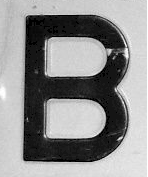

Label: B
Prediction: B


In [107]:
#TODO: Test on image (link below) with Fourier Descriptors
#https://drive.google.com/file/d/1rPsE-M0kxTF_03cZ3sEKhJ2rCc1TgpYp/view?usp=sharing
img = cv2.imread("/content/drive/My Drive/B (test).png", 0)
#img = images[5]

#TODO: find descriptors -  see findDescriptor
#code here
fd = findDescriptor(img)
#TODO: truncate descriptor - see truncate_descriptor
#code here
trunc = truncate_descriptor(fd,18)
#TODO: scale to [0, 1] range the truncated descriptor - see scale_range
#code here
fd_img = scale_range(trunc.astype('float'),0,1)
#create input to SVM (fd_imag is the scaled truncated descriptor)
FD_feature = np.hstack([fd_img.real, fd_img.imag])
testData = np.matrix(FD_feature, dtype=np.float32)
print(testData)
#TODO: feed testData input to SVM (see predict function)
#code here
response = svm.predict(testData)[1]
predicted_label = int(response[0][0])
cv2_imshow(img)
print("Label: B")
print("Prediction: " + chr(65+int(predicted_label)))

### Train&Test SVM with Hu Moments

In [95]:
#TODO: feature extraction of Hu moments for each image, result is a list of lists (global_features)
global_features = []

#code here
for img in images:
    hu_moments = fd_hu_moments(img)
    global_features.append(hu_moments)

In [96]:
#TODO: set up labels & training data
#code here
class_labels = np.array(labels)
trainingData = np.matrix(global_features,dtype=np.float32)
print(class_labels.shape)
print(trainingData.shape)

(22,)
(22, 7)


In [97]:
#TODO: Train the SVM with the new training data (Hu moments)
#code here
svm.train(trainingData, cv.ml.ROW_SAMPLE, class_labels)


True

[[1.00000000e+00 1.20154764e-04 1.60702989e-08 5.10864073e-10
  7.11140208e-22 5.86170923e-14 0.00000000e+00]]


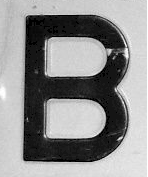

Label: B
Prediction: A


In [98]:
#TODO: Test on image with Hu Moments
img = cv2.imread("/content/drive/My Drive/B (test).png", 0)

#TODO: compute Hu moments - see fd_hu_moments
#code here
hu_moments = fd_hu_moments(img)
#TODO: scale the Hu moments to [0, 1] - see scale_range
#code here
hu_moments_min = np.min(hu_moments)
hu_moments_max = np.max(hu_moments)

hu_moments_scaled = (hu_moments - hu_moments_min) / (hu_moments_max - hu_moments_min)

#TODO: cast test data to float32 matrix - see np.matrix
#code here
test_data = np.matrix(hu_moments_scaled, dtype=np.float32)
print(test_data)

#TODO: feed data to SVM
#code here
response,_ = svm.predict(test_data)
cv2_imshow(img)
#print("Label: "+chr(labels[16]+65))
print("Label: B")
print("Prediction: "+chr(65+int(response)))

### Train&Test with Fourier Descriptors and Hu Moments

In [108]:
##TODO: feature extraction FD + Hu Moments for each image
NUM_DESCRIPTORS = 18
global_features = []

#code here
for img in images:
  fd = findDescriptor(img)
  hu_moments = fd_hu_moments(img)
  descriptors = truncate_descriptor(fd, NUM_DESCRIPTORS)
  descriptors = scale_range(descriptors, 0, 1)
  fd_feature = np.hstack([descriptors.real, descriptors.imag])
  global_feature = np.hstack([fd_feature, hu_moments])
  global_features.append(global_feature)


In [109]:
#set up training data
class_labels = np.array(labels)
trainingData = np.matrix(global_features,dtype=np.float32)
print(class_labels.shape)
print(trainingData.shape)

(22,)
(22, 43)


In [110]:
#TODO: Train the SVM
#code here
svm.train(trainingData, cv.ml.ROW_SAMPLE, class_labels)

True

[[1.0000000e+00 4.2527178e-01 3.3533832e-01 2.8616855e-01 3.5720268e-01
  3.4617788e-01 3.4726548e-01 3.5396993e-01 3.5478124e-01 3.5076481e-01
  3.5175788e-01 3.4759191e-01 3.3836931e-01 3.6336809e-01 3.5877639e-01
  3.0077597e-01 3.2939178e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0000000e+00 1.0977796e-04 5.6514811e-09 8.8239309e-09
  1.5148859e-19 2.9868586e-12 0.0000000e+00]]


<ipython-input-111-33f6d08bcba2>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  fd_img = scale_range(trunc.astype('float'),0,1)


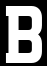

Label: B
Prediction: B


In [111]:
#TODO: Test on random image with FD + Hu Moments
img = images[16]
#code here

hu_moments = fd_hu_moments(img)
#TODO: scale the Hu moments to [0, 1] - see scale_range
#code here
hu_moments_min = np.min(hu_moments)
hu_moments_max = np.max(hu_moments)
hu_moments_scaled = (hu_moments - hu_moments_min) / (hu_moments_max - hu_moments_min)


fd = findDescriptor(img)
trunc = truncate_descriptor(fd,18)
fd_img = scale_range(trunc.astype('float'),0,1)
FD_feature = np.hstack([fd_img.real, fd_img.imag])

combined_feature = np.hstack([FD_feature, hu_moments_scaled])
testData = np.matrix(combined_feature, dtype=np.float32)

print(testData)

response = svm.predict(testData)[1]
predicted_label = int(response[0][0])

cv2_imshow(images[16])
print("Label: "+chr(labels[16]+65))
print("Prediction: "+chr(65+predicted_label))

In [ ]:
#TODO: Add to the training dataset all uppercase letters, train & test the SVM, is it performing good enough? find a classifier that performs better

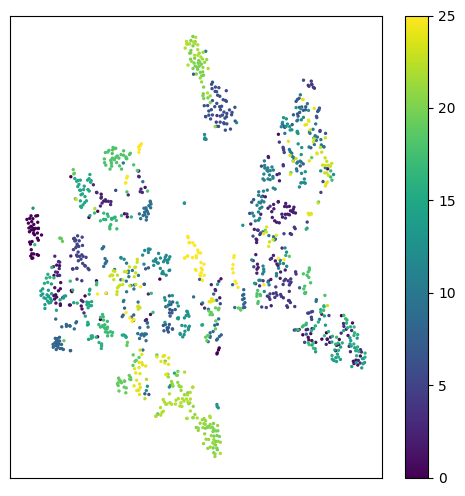

In [ ]:
#TODO: Use TSNE to view a 2D representation of features.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.5951048951048951
Precision: 0.6199987405990853
Recall: 0.5951048951048951
F1-score: 0.5841699897964019


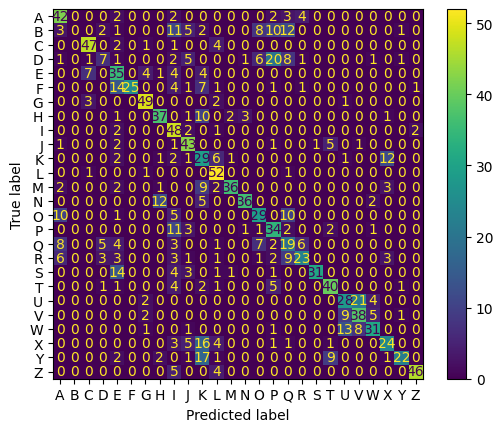

In [ ]:
#TODO: compute evaluation metrics and confusion matrix